<a href="https://colab.research.google.com/github/Jersae/explore_shapley/blob/master/shapley.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Blank Intentionally because nobody codes on the first block! Ever! :)

#Author: Phua Chee Wee

#GitLink: https://github.com/Jersae

# Shapley Implementation Trial 

Gonna feed in a pandas table and try to extract shapley value from it and try to make sense of it.


In [54]:
!pip install shap

In [0]:
import pandas as pd
import shap  # package used to calculate Shap values
from sklearn.ensemble import RandomForestClassifier #random forest


In [0]:
# 4 Signals (Signal 1 being strongest to Signal 4), varying thresholds for each signal
# Assune an id will be flagged as True for the following conditions:
# Trigger Condition: Flag is 1 if (S1 + S2) | (S1 + S3 + S4) | (S2 + S3 + S4) | (S1 + S2  S3 + S4) | (S1 + S3|S4) | (S2 + S3|S4), else 0
# These conditions will not be explicitly stated out in the code but the data will generally follow this pattern
# Threshold Values of Signals are {"S1": 0.5, "S2": 0.7, "S3": 0.9, "S4": 0.95}

threshold = {"S1": 0.5, "S2": 0.7, "S3": 0.9, "S4": 0.95}

import random
num_traindata = 30
train_data = []

def generate_data(i, trigger_ratio = 0.5):
  """
  trigger_Ratio: float 0.5 means equal chnace of data generated having flag 1 and flag 0. higher than 0.5 means more chance of flag 1
  """
  chance = random.uniform(0, 1)

  if chance < 0.5:
    # Flag 1 data generated
    #Which of (S1 + S2) | (S1 + S3 + S4) | (S2 + S3 + S4) | (S1 + S2  S3 + S4) | (S1 + S3|S4) | (S2 + S3|S4) to be generated
    case_chance = random.uniform(0, 1)

    if case_chance > 0.875:
      return ("id{}".format(i), random.uniform(threshold["S1"], 1), random.uniform(threshold["S2"], 1), random.uniform(0, threshold["S3"]), random.uniform(0, threshold["S4"]), 1)

    elif case_chance > 0.75:
      return ("id{}".format(i), random.uniform(threshold["S1"], 1), random.uniform(0, threshold["S2"]), random.uniform(threshold["S3"], 1), random.uniform(threshold["S4"], 1), 1)

    elif case_chance > 0.625:
      return ("id{}".format(i), random.uniform(0, threshold["S1"]), random.uniform(threshold["S2"], 1), random.uniform(threshold["S3"], 1), random.uniform(threshold["S4"], 1), 1)

    elif case_chance > 0.5:
      return ("id{}".format(i), random.uniform(threshold["S1"], 1), random.uniform(threshold["S2"], 1), random.uniform(threshold["S3"], 1), random.uniform(threshold["S4"], 1), 1)

    elif case_chance > 0.375:
      return ("id{}".format(i), random.uniform(threshold["S1"], 1), random.uniform(0, threshold["S2"]), random.uniform(threshold["S3"], 1), random.uniform(0, threshold["S4"]), 1)

    elif case_chance > 0.25:
      return ("id{}".format(i), random.uniform(threshold["S1"], 1), random.uniform(0, threshold["S2"]), random.uniform(0, threshold["S3"]), random.uniform(threshold["S4"], 1), 1)

    elif case_chance > 0.125:
      return ("id{}".format(i), random.uniform(0, threshold["S1"]), random.uniform(threshold["S2"], 1), random.uniform(threshold["S3"], 1), random.uniform(0, threshold["S4"]), 1)

    else:
      return ("id{}".format(i), random.uniform(0, threshold["S1"]), random.uniform(threshold["S2"], 1), random.uniform(0, threshold["S3"]), random.uniform(threshold["S4"], 1), 1)

  else:
    # Flag 0 data generated
    # case conditions: (S3 &| S4) | {S1|S2} 

    case_chance = random.uniform(0, 1)
    if case_chance > 0.75:
      return ("id{}".format(i), random.uniform(0, threshold["S1"]), random.uniform(0, threshold["S2"]), random.uniform(threshold["S3"], 1), random.uniform(0, threshold["S4"]), 0)

    elif case_chance > 0.5:
      return ("id{}".format(i), random.uniform(0, threshold["S1"]), random.uniform(0, threshold["S2"]), random.uniform(0, threshold["S3"]), random.uniform(threshold["S4"], 1), 0)
    
    elif case_chance > 0.25:
      return ("id{}".format(i), random.uniform(0, threshold["S1"]), random.uniform(threshold["S2"], 1), random.uniform(0, threshold["S3"]), random.uniform(0, threshold["S4"]), 0)

    else:
      return ("id{}".format(i), random.uniform(threshold["S1"], 1), random.uniform(0, threshold["S2"]), random.uniform(0, threshold["S3"]), random.uniform(0, threshold["S4"]), 0)

for i in range(0, num_traindata):
  train_data.append(generate_data(i))
train_data

def train_test_data(num, train_ratio = 0.5):
  train_data = []
  test_data = []

  for i in range(0, int(num*train_ratio)):
    train_data.append(generate_data(i))

  for i in range(int(num*train_ratio), num):
    test_data.append(generate_data(i))

  return train_data, test_data

In [130]:
num_samples = 10000
train_data, test_data = train_test_data(num_samples, train_ratio= 0.8)

column_names = ["id", "signal1", "signal2", "signal3", "signal4", "flag"]

df = pd.DataFrame(train_data, columns = column_names)

test_df = pd.DataFrame(test_data, columns = column_names)

features = ["signal1", "signal2", "signal3", "signal4"]

"""
#Assuming some labels are labelled incorrectly. (Imperfect environment) 10. Implement to test if neccessary
dfupdate = df.sample(10)
dfupdate["flag"] = dfupdate["flag"].apply(lambda x: 1 if x == 0 else 0)
df.update(dfupdate)
"""

'\n#Assuming some labels are labelled incorrectly. (Imperfect environment) 10. Implement to test if neccessary\ndfupdate = df.sample(10)\ndfupdate["flag"] = dfupdate["flag"].apply(lambda x: 1 if x == 0 else 0)\ndf.update(dfupdate)\n'

In [132]:
clf = RandomForestClassifier(n_jobs=-1, random_state=0)
clf.fit(df[features], df["flag"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [131]:
clf.predict(test_df[features])

array([1., 1., 0., ..., 1., 1., 0.])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


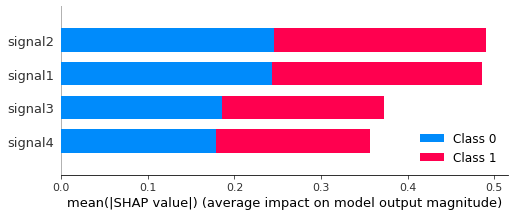

In [133]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(df[features])
df[features].columns
#shap.summary_plot(shap_values, features=df[features], feature_names=df[features].columns)
shap.summary_plot(shap_values, features=df[features])

In [168]:
# Unpacking Sahpely value for each feature
S1 = []
S2 = []
S3 = []
S4 = []

for i in shap_values[0]:
  S1.append(abs(i[0]))
  S2.append(abs(i[1]))
  S3.append(abs(i[2]))
  S4.append(abs(i[3]))

for i in shap_values[1]:
  S1.append(abs(i[0]))
  S2.append(abs(i[1]))
  S3.append(abs(i[2]))
  S4.append(abs(i[3]))

import numpy as np
shap_S1 = np.mean(S1)
shap_S2 = np.mean(S2)
shap_S3 = np.mean(S3)
shap_S4 = np.mean(S4)

shap_sum = sum([shap_S1, shap_S2, shap_S3, shap_S4])

print(shap_sum, shap_S1, shap_S2, shap_S3, shap_S4)

print("S1, S2, S3, S4 scores can be combined using in the porpotion of S1: {}, S2: {}, S3: {}, S4: {}".format((shap_S1/shap_sum), (shap_S2/shap_sum), (shap_S3/shap_sum), (shap_S4/shap_sum)))


0.8527485165215125 0.24301001002687364 0.24542479595256153 0.18614809414499153 0.17816561639708578
S1, S2, S3, S4 scores can be combined using in the porpotion of S1: 0.28497265643820463, S2: 0.2878044243966388, S3: 0.21829190029472836, S4: 0.2089310188704282


As Expected, Signal 1 and 2 are identified as the main signal with higher shapley value than signal 3 and 4. 

Signal 1 and 2 have almost similar shapley value despite different thresholds. So does signal 3 and 4 as well.

This concludes my trial on shapley value to distinguish feature importance.